## Section Two: Deep Learning - Semantic Segmentation on Sentinel-2 Imagery
In this section, you will implement a pipeline that performs semantic segmentation on Sentinel-2
imagery using a pretrained model. At this stage, we want to perform basic segmentation on 3 or
so classes: Water, Vegetation and Buildings.

#### Objective:
Given:
- An AOI (given as GeoJSON).
- A target date (You may select any date within the last 5 years)

Your task is to:
- Download the Sentinel-2 data for the target date for that AOI. If data is unavailable for
the target date, retrieve data for the closest available date.
- Select a pretrained model suited to this task. Important: Explain why you picked this
model. Don’t hesitate to go into detail here, on the training dataset used, the
performance metrics, tradeoffs etc. We intentionally did not preselect a model, as we
want to assess and understand your model selection process. This is a key skill we will
be looking at.
- Process the data to the right format for the model
- Output predictions for our AOI and target date using the selected model. We do not
expect a specific output type, just the one outputted by the model (csv, GeoTIFF, png).
You are expected to submit the output along with your code.

#### Notes:
- You may use either PyTorch or Tensorflow.
- If the AOI generates too large of a GeoTIFF for reasonable inference times, you are
allowed to reduce the area accordingly.
- In this section, **you are not expected to fine-tune the model**, but use it as is.

https://github.com/pavlo-seimskyi/semantic-segmentation-satellite-imagery

https://github.com/stolarinhoo/Sentinel-2-Satellite-Images-Semantic-Segmentation-with-U-NET_Deep-Learning-approach

https://www.mathworks.com/help/images/classify-land-cover-using-sentinel-2-multispectral-images.html

https://documentation.dataspace.copernicus.eu/APIs/openEO/openeo-community-examples/python/ParcelDelineation/Parcel%20delineation.html

https://torchgeo.readthedocs.io/en/latest/api/models.html#pretrained-weights

https://huggingface.co/odil111/yolov8m-seg-fine-tuned-on-spacenetv2/tree/main

https://huggingface.co/odil111/unet-fine-tuned-on-openearthmap/tree/main

https://huggingface.co/dcrey7/wetlands_segmentation_deeplabsv3plus/tree/main

https://huggingface.co/martinkorelic/dpr-zoo-models/tree/main

https://satlas-pretrain.allen.ai/


In [ ]:
import json
from datetime import datetime
import matplotlib.pyplot as plt

### Définition des paramètres

In [2]:
target_date = datetime(2022, 8, 30).strftime("%Y-%m-%d")
cloud_cover_limit = 20

AOI_path = '../AOI_Rubicon.geojson'
with open(AOI_path, 'r') as file:
    geojson_data = json.load(file)["features"][0]["geometry"]

### Génération des pngs pour la date voulue

In [ ]:
from rubicon_cs.main import png_for_target_date

#use rgb_optimized for Sentinel-2 L2A True Color Optimized from https://custom-scripts.sentinel-hub.com/sentinel-2/l2a_optimized/ or rgb for raw colors but needs postprocessing like brightening up
png_for_target_date(AOI=geojson_data, target_date=target_date, cloud_cover_limit=cloud_cover_limit, rgb_evalscript='rgb_optimized')

/home/mathieujayet/.pyenv/versions/rubicon/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using nearest available date: 2022-09-01
Saved RGB image for 2022-09-01 to rgb_2022-09-01.png


https://bigearth.net/#about

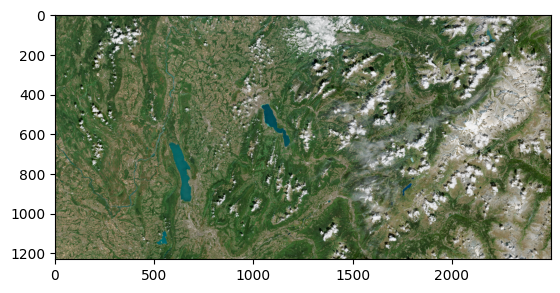

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

img_path = "rgb_2022-09-01.png"
image = Image.open(img_path)

plt.imshow(image)
plt.show()

In [ ]:
import torch
import satlaspretrain_models

# #If you have problems accessing gpu on colab
# # Override torch.load to always map to CPU
# original_torch_load = torch.load

# def cpu_load(*args, **kwargs):
#     kwargs['map_location'] = torch.device('cpu')
#     return original_torch_load(*args, **kwargs)

# torch.load = cpu_load  # Patch torch.load

# Load model
weights_manager = satlaspretrain_models.Weights()
MODEL_CHECKPOINT_ID = "Sentinel2_SwinB_SI_RGB"
model = weights_manager.get_pretrained_model(
    MODEL_CHECKPOINT_ID,
    fpn=True,
    head=satlaspretrain_models.Head.SEGMENT,
    num_categories=12
)

: 

In [15]:
!wget "https://huggingface.co/martinkorelic/dpr-zoo-models/resolve/main/Satlas_RGB2_epoch100.pth" -O ../models/Satlas_RGB2_epoch100.pth

weights_path = "../models/Satlas_RGB2_epoch100.pth"  # Path to the downloaded .pth weights
weights = torch.load(weights_path, map_location=torch.device('cpu'))
model.load_state_dict(weights, strict=False)


# Set the model to evaluation mode (important for inference)
model.eval()

--2025-04-21 16:55:18--  https://huggingface.co/martinkorelic/dpr-zoo-models/resolve/main/Satlas_RGB2_epoch100.pth
Resolving huggingface.co (huggingface.co)... 18.155.129.31, 18.155.129.60, 18.155.129.129, ...
Connecting to huggingface.co (huggingface.co)|18.155.129.31|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/a6/41/a641d504f8089317802476f84910dad8f8be962d3cf96b55677b600b7257f893/79166215a93af1847289868a6185fa031a0d5a3c8afd50f42fc19c250031ca18?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27Satlas_RGB2_epoch100.pth%3B+filename%3D%22Satlas_RGB2_epoch100.pth%22%3B&Expires=1745250918&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NTI1MDkxOH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2E2LzQxL2E2NDFkNTA0ZjgwODkzMTc4MDI0NzZmODQ5MTBkYWQ4ZjhiZTk2MmQzY2Y5NmI1NTY3N2I2MDBiNzI1N2Y4OTMvNzkxNjYyMTVhOTNhZjE4NDcyODk4NjhhNjE4NWZhMDMxYTBkNWEzYzhhZmQ1MGY0MmZjM

NameError: name 'model' is not defined

In [ ]:
# Load your RGB image (tif, jpg, png)
from torchvision import transforms

try:
    image = Image.open(img_path)
    # Resize to match model expectations (512*512) but the best approach is to feed the model with an image already this size
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])

    input_tensor = transform(image).unsqueeze(0)  # shape: [1, 3, 512, 512]
    print(input_tensor.shape)

except OSError as e:
    print(f"Error loading image: {e}")

In [ ]:
# with torch.no_grad():
output = model(input_tensor)  # output is a dict 
logits = output[0]        # shape: [1, num_classes, H, W]

# Get predicted class for each pixel, applying argmax along the class dimension (dim=1)
pred = torch.argmax(logits, dim=1).squeeze().cpu().numpy()  # shape: [H, W]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define your custom colormap (12 colors, one for each class)
colormap = [
    [0, 0, 0],          # 0: background
    [0, 0, 255],        # 1: water
    [255, 0, 0],        # 2: developed
    [0, 192, 0],        # 3: tree
    [200, 170, 120],    # 4: shrub
    [0, 255, 0],        # 5: grass
    [255, 255, 0],      # 6: crop
    [128, 128, 128],    # 7: bare
    [255, 255, 255],    # 8: snow
    [0, 255, 255],      # 9: wetland
    [255, 0, 255],      # 10: mangroves
    [128, 0, 128]       # 11: moss
]

# Define the class labels
labels = [
    "background",
    "water",
    "developed",
    "tree",
    "shrub",
    "grass",
    "crop",
    "bare",
    "snow",
    "wetland",
    "mangroves",
    "moss"
]

# Convert predicted classes to RGB colors
mask_rgb = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)  # Shape: (512, 512, 3)

# Loop over each class (0 to 11) and apply the corresponding color from the colormap
for i in range(12):  # 12 classes
    mask_rgb[pred == i] = colormap[i]

# Visualize the RGB segmentation mask
plt.imshow(mask_rgb)
plt.title("Segmentation Output")

# Create a legend with the class labels
patches = [mpatches.Patch(color=np.array(colormap[i])/255, label=labels[i]) for i in range(len(labels))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

plt.imshow(image)
plt.show()

In [ ]:
# Simplified colormap (only 3 categories)
simplified_colormap = [
    [0, 0, 255],        # Water
    [0, 192, 0],        # Vegetation
    [255, 0, 0],        # Buildings
]

# Simplified labels for the new categories
simplified_labels = [
    "Water",
    "Vegetation",
    "Buildings"
]

# Create a new mask to assign each pixel to one of the simplified categories
simplified_pred = np.zeros_like(pred)  # Create a new mask with the same shape

# Assign categories based on original class
# Water: class 1 (water)
simplified_pred[pred == 1] = 0  # Water class
# Vegetation: classes 3, 4, 5, 6, 9, 10, 11 (tree, shrub, grass, crop, wetland, mangroves, moss)
simplified_pred[np.isin(pred, [3, 4, 5, 6, 9, 10, 11])] = 1  # Vegetation class
# Buildings: classes 2, 7 (developed, bare)
simplified_pred[np.isin(pred, [2, 7])] = 2  # Buildings class

# Convert simplified prediction to RGB mask
mask_rgb = np.zeros((simplified_pred.shape[0], simplified_pred.shape[1], 3), dtype=np.uint8)  # Shape: (512, 512, 3)

# Loop over each simplified class (Water, Vegetation, Buildings)
for i in range(3):  # 3 categories
    mask_rgb[simplified_pred == i] = simplified_colormap[i]

# Visualize the RGB segmentation mask
plt.imshow(mask_rgb, alpha = 1)
plt.title("Simplified Segmentation Output")

# Create a legend with the simplified class labels
patches = [mpatches.Patch(color=np.array(simplified_colormap[i])/255, label=simplified_labels[i]) for i in range(len(simplified_labels))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.imshow(image, alpha=0.4)
plt.show()

plt.imshow(image)
plt.show()